Loaded 26 ground truth records from exp_data_1_per_group_NeurIPS2024/sampled_flaws.csv


Loading predictions: 100%|██████████| 26/26 [00:00<00:00, 363.94it/s]


==================== Classification Report ====================
              precision    recall  f1-score   support

          1a       0.00      0.00      0.00         1
          1b       0.00      0.00      0.00         1
          1c       0.00      0.00      0.00         2
          1d       0.00      0.00      0.00         2
          2a       0.00      0.00      0.00         0
          2b       0.00      0.00      0.00         1
          2c       0.00      0.00      0.00         1
          3a       0.00      0.00      0.00         1
          3b       0.00      0.00      0.00         1
          4a       0.00      0.00      0.00         2
          4b       0.50      1.00      0.67         2
          5a       0.00      0.00      0.00         0
          5b       0.00      0.00      0.00         1

   micro avg       0.03      0.13      0.05        15
   macro avg       0.04      0.08      0.05        15
weighted avg       0.07      0.13      0.09        15
 samples avg   


/Users/ktgiahieu/miniconda3/envs/checklist/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['"1a', '"1b', '"1b"', '"2a', '"2a"', '"2b', '"2b"', '"2c', '"3a', '"3b"', '"5b"', '1d"', '4a"', '5a"'] will be ignored
  warnings.warn(


F1 (Micro):   0.0526
F1 (Macro):   0.0513
F1 (Weighted): 0.0889
F1 (Samples): 0.0410

==================== Per-Class TP/FP/FN ====================
   Class  TP  FP  FN  TN
0     1a   0   1   1  24
1     1b   0   3   1  22
2     1c   0   3   2  21
3     1d   0   4   2  20
4     2a   0   1   0  25
5     2b   0   3   1  22
6     2c   0   1   1  24
7     3a   0   1   1  24
8     3b   0  12   1  13
9     4a   0  10   2  14
10    4b   2   2   0  22
11    5a   0  17   0   9
12    5b   0   1   1  24


Heatmap saved to flaw_heatmap.png


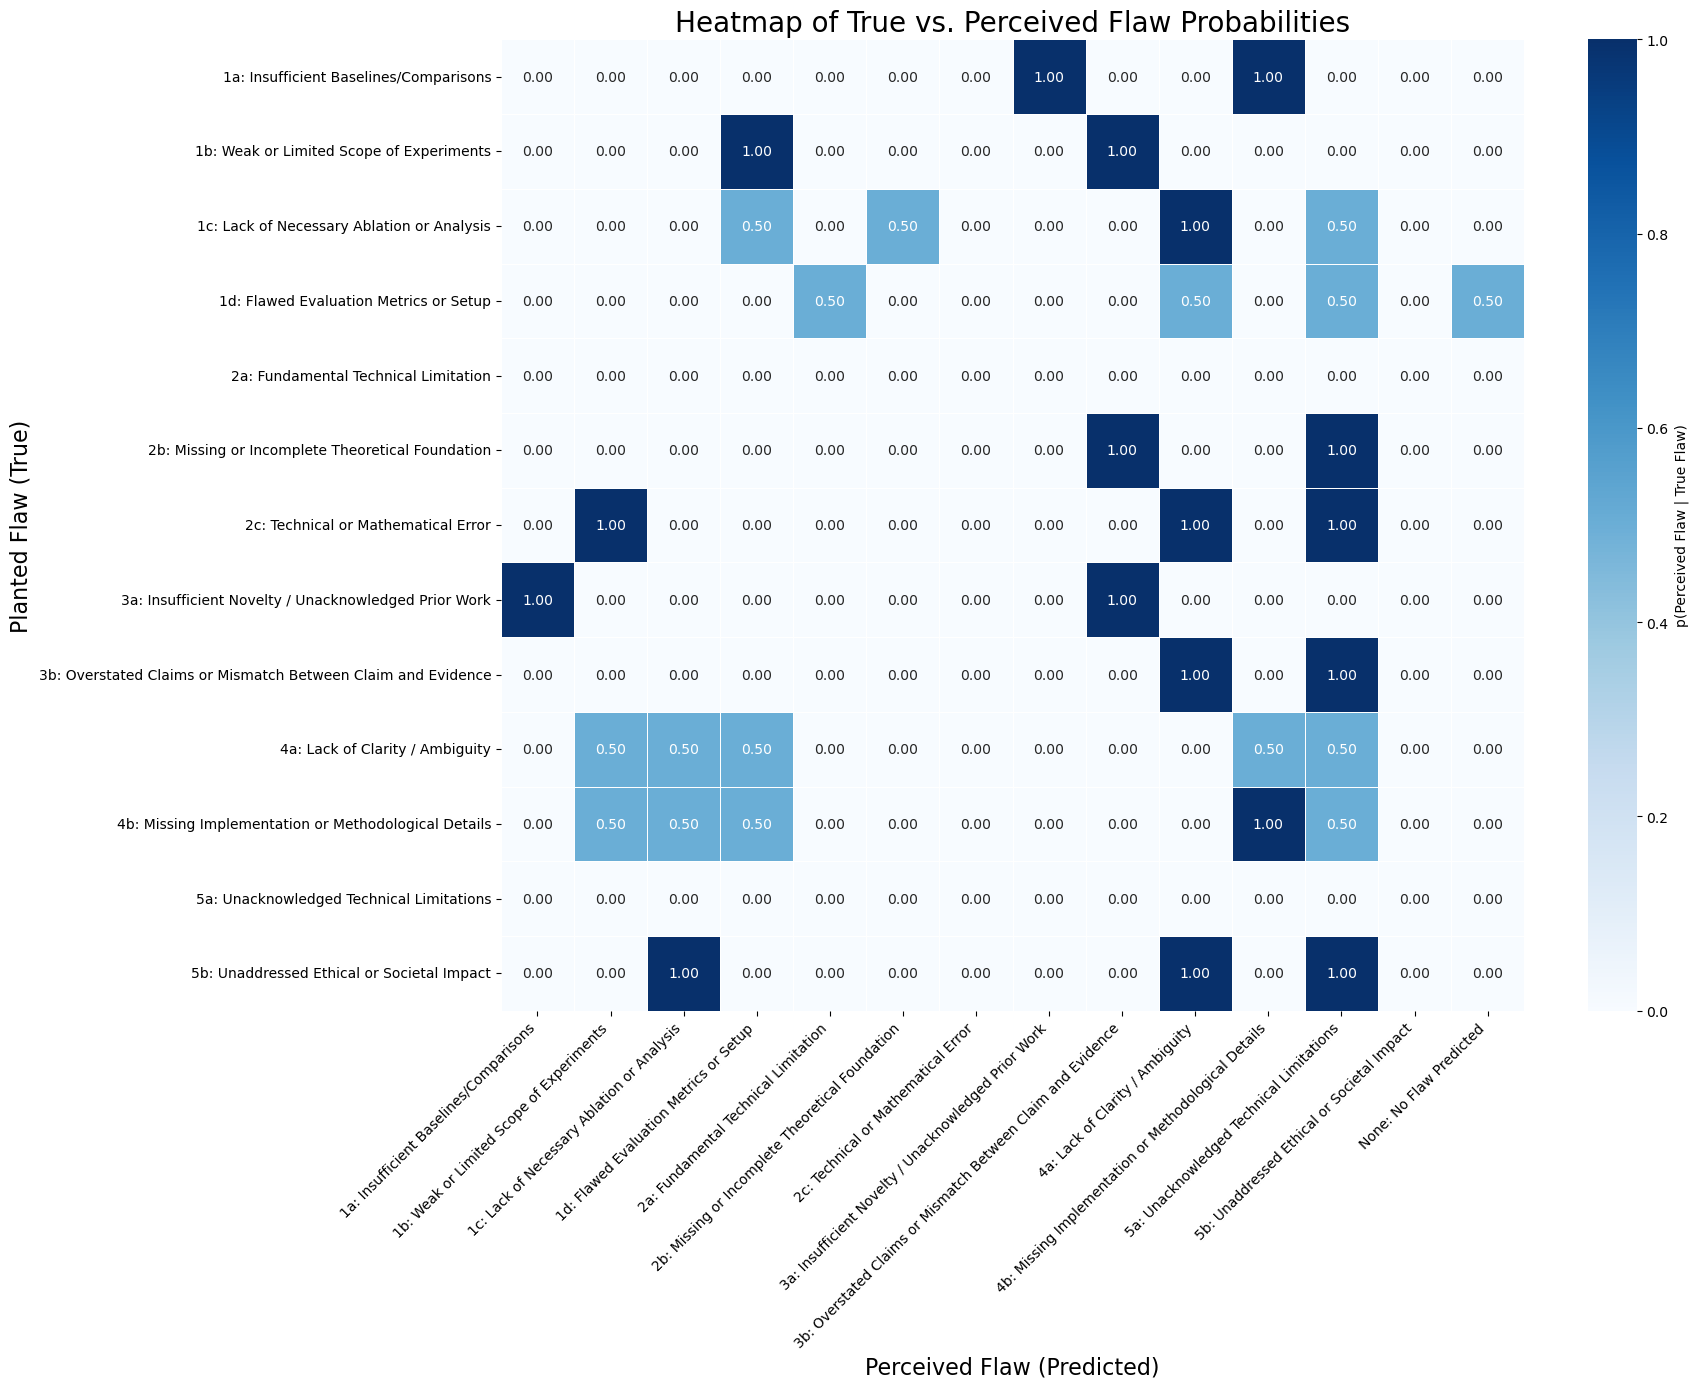

In [4]:
import os
import json
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, f1_score, multilabel_confusion_matrix
# Note: Ensure you have run `pip install pandas seaborn matplotlib scikit-learn tqdm` in your notebook environment

# --- Flaw Taxonomy ---
# Copied from review_with_anthropic_modified.py for self-contained script
FLAW_TAXONOMY_STR = """
Category 1: Empirical Evaluation Flaws
(Concerns the experiments and evidence used to support the claims.)
1a: Insufficient Baselines/Comparisons
1b: Weak or Limited Scope of Experiments
1c: Lack of Necessary Ablation or Analysis
1d: Flawed Evaluation Metrics or Setup

Category 2: Methodological & Theoretical Flaws
(Concerns the core technical contribution—the algorithm, model, or theory itself.)
2a: Fundamental Technical Limitation
2b: Missing or Incomplete Theoretical Foundation
2c: Technical or Mathematical Error

Category 3: Positioning & Contribution Flaws
(Concerns how the work is framed and what it claims to contribute.)
3a: Insufficient Novelty / Unacknowledged Prior Work
3b: Overstated Claims or Mismatch Between Claim and Evidence

Category 4: Presentation & Reproducibility Flaws
(Concerns the quality of the writing and the ability for others to understand and use the work.)
4a: Lack of Clarity / Ambiguity
4b: Missing Implementation or Methodological Details

Category 5: Failure to Address Limitations or Ethical Concerns
(Concerns the omission of a proper discussion of the work's boundaries and potential consequences.)
5a: Unacknowledged Technical Limitations
5b: Unaddressed Ethical or Societal Impact
"""

def parse_flaw_taxonomy(taxonomy_str: str):
    """Parses the flaw taxonomy string into a list of codes and a code-to-description map."""
    flaw_codes = []
    flaw_code_to_desc = {}
    pattern = re.compile(r'(\d+[a-z]):\s*(.*)')
    
    for line in taxonomy_str.splitlines():
        match = pattern.match(line.strip())
        if match:
            code = match.group(1)
            description = match.group(2)
            flaw_codes.append(code)
            flaw_code_to_desc[code] = f"{code}: {description}"
            
    flaw_code_to_desc['None'] = "None: No Flaw Predicted"
    return sorted(flaw_codes), flaw_code_to_desc

def clean_flaw_string(flaw_str: str) -> list:
    """Cleans the comma-separated flaw string from JSON into a list of codes."""
    if not isinstance(flaw_str, str) or not flaw_str.strip():
        return []
    # Split on commas or whitespace, filter out empty strings
    return sorted(list(set(filter(None, re.split(r'[,\s]+', flaw_str.strip())))))

def load_data(csv_file: Path, reviews_dir: Path):
    """Loads ground truth from CSV and predictions from JSON files."""
    try:
        df_truth = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"Error: Ground truth CSV not found at {csv_file}")
        return None
    
    print(f"Loaded {len(df_truth)} ground truth records from {csv_file}")
    
    records = []
    
    # --- MODIFICATION ---
    # The standard `tqdm` package will automatically detect notebook environments
    # and fall back gracefully to a text bar if ipywidgets is missing.
    # This avoids the hard crash caused by `from tqdm.notebook import ...`
    progress_bar = tqdm
    # --- END MODIFICATION ---

    for _, row in progress_bar(df_truth.iterrows(), total=len(df_truth), desc="Loading predictions"):
        # Assuming first column is paper ID, as seen in screenshot
        paper_id = str(row.iloc[0]).split(',')[0].strip()
        
        # --- MODIFICATION: Treat true_flaw as a list, just like predicted ---
        # Get ground truth flaw. It can also be a comma-separated list.
        true_flaw_str = row.get('category_ids')
        if not true_flaw_str or not isinstance(true_flaw_str, str):
            print(f"Warning: Skipping {paper_id}, missing or invalid 'category_ids'.")
            continue
            
        true_flaws_list = clean_flaw_string(true_flaw_str)
        if not true_flaws_list:
            print(f"Warning: Skipping {paper_id}, 'category_ids' was empty after cleaning.")
            continue
        # --- END MODIFICATION ---
        
        # Load prediction
        prediction_file = reviews_dir / paper_id / "flaw_analysis_0.json"
        
        predicted_flaws = []
        if prediction_file.exists():
            try:
                with open(prediction_file, 'r', encoding='utf-8') as f:
                    pred_data = json.load(f)
                
                # 'flaw_types' is the comma-separated string
                predicted_flaws_str = pred_data.get('flaw_types', '')
                predicted_flaws = clean_flaw_string(predicted_flaws_str)
            except json.JSONDecodeError:
                print(f"Warning: Could not parse JSON for {paper_id}. Skipping.")
        else:
            print(f"Warning: No prediction file found for {paper_id}. Skipping.")
            
        records.append({
            "paper_id": paper_id,
            "true_flaw": true_flaws_list, # Store the list of true flaws
            "predicted_flaws": predicted_flaws
        })
        
    return pd.DataFrame(records)

def calculate_metrics(df: pd.DataFrame, all_flaw_codes: list):
    """Calculates and prints F1, Precision, Recall, TP, FP, FN."""
    
    # --- MODIFICATION: true_flaw is now already a list ---
    y_true_lists = df['true_flaw']
    # --- END MODIFICATION ---
    y_pred_lists = df['predicted_flaws']
    
    # Binarize the labels
    mlb = MultiLabelBinarizer(classes=all_flaw_codes)
    y_true = mlb.fit_transform(y_true_lists)
    y_pred = mlb.transform(y_pred_lists)
    
    print("\n" + "="*20 + " Classification Report " + "="*20)
    report = classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0)
    print(report)
    
    print("\n" + "="*20 + " Overall F1 Scores " + "="*20)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_samples = f1_score(y_true, y_pred, average='samples', zero_division=0)
    
    print(f"F1 (Micro):   {f1_micro:.4f}")
    print(f"F1 (Macro):   {f1_macro:.4f}")
    print(f"F1 (Weighted): {f1_weighted:.4f}")
    print(f"F1 (Samples): {f1_samples:.4f}")
    
    print("\n" + "="*20 + " Per-Class TP/FP/FN " + "="*20)
    # Get multilabel confusion matrix
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    
    tp = mcm[:, 1, 1]
    tn = mcm[:, 0, 0]
    fp = mcm[:, 0, 1]
    fn = mcm[:, 1, 0]
    
    metrics_df = pd.DataFrame({
        'Class': mlb.classes_,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn
    })
    print(metrics_df)
    print("\n")

def plot_heatmap(df: pd.DataFrame, all_flaw_codes: list, flaw_code_to_desc: dict):
    """Generates and shows a heatmap of p(predicted | true)."""
    
    # --- MODIFICATION: Iterate over all known flaw codes for the Y-axis ---
    unique_true_flaws = all_flaw_codes 
    # --- END MODIFICATION ---
    all_possible_predicted_flaws = all_flaw_codes + ['None'] # Add 'None' for empty predictions
    
    analysis_records = []
    
    for true_flaw in unique_true_flaws:
        # --- MODIFICATION: Find all rows where 'true_flaw' is in the 'true_flaw' list ---
        subset_df = df[df['true_flaw'].apply(lambda flaw_list: true_flaw in flaw_list)]
        # --- END MODIFICATION ---
        n_total = len(subset_df)
        if n_total == 0:
            # Still append records with 0 probability to ensure a full matrix
            for p_flaw in all_possible_predicted_flaws:
                analysis_records.append({
                    "true_flaw_desc": flaw_code_to_desc.get(true_flaw, true_flaw),
                    "perceived_flaw_desc": flaw_code_to_desc.get(p_flaw, p_flaw),
                    "probability": 0.0
                })
            continue
            
        for p_flaw in all_possible_predicted_flaws:
            if p_flaw == 'None':
                # Count papers where prediction list was empty
                k_successes = subset_df['predicted_flaws'].apply(lambda x: len(x) == 0).sum()
            else:
                # Count papers where this flaw was in the prediction list
                k_successes = subset_df['predicted_flaws'].apply(lambda x: p_flaw in x).sum()
                
            probability = k_successes / n_total
            
            analysis_records.append({
                "true_flaw_desc": flaw_code_to_desc.get(true_flaw, true_flaw),
                "perceived_flaw_desc": flaw_code_to_desc.get(p_flaw, p_flaw),
                "probability": probability
            })
            
    results_df = pd.DataFrame(analysis_records)
    
    # --- Plotting logic based on your example ---
    
    ## 1. Pivot the Data
    heatmap_data = results_df.pivot_table(
        index='true_flaw_desc',
        columns='perceived_flaw_desc',
        values='probability'
    )
    
    # Ensure all columns are present, even if no predictions were made for them
    all_desc_cols = [flaw_code_to_desc.get(c, c) for c in all_possible_predicted_flaws]
    # Ensure all rows are present
    all_desc_rows = [flaw_code_to_desc.get(c, c) for c in unique_true_flaws]

    # Reindex to ensure all rows and columns are present in the correct order
    heatmap_data = heatmap_data.reindex(index=all_desc_rows, columns=all_desc_cols, fill_value=0.0)

    ## 2. Generate and Customize the Heatmap
    plt.figure(figsize=(18, 14))

    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".2f",
        cmap='Blues',
        linewidths=.5,
        cbar_kws={'label': 'p(Perceived Flaw | True Flaw)'}
    )

    ## 3. Final Touches
    plt.title(f"Heatmap of True vs. Perceived Flaw Probabilities", fontsize=20)
    plt.xlabel('Perceived Flaw (Predicted)', fontsize=16)
    plt.ylabel('Planted Flaw (True)', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save the figure
    output_filename = "flaw_heatmap.png"
    plt.savefig(output_filename)
    print(f"Heatmap saved to {output_filename}")
    plt.show() # Display the plot inline in the notebook


def main():
    # --- MODIFICATION: Set paths directly ---
    # !! Edit these paths to match your notebook's file structure !!
    CSV_FILE_PATH = "./exp_data_1_per_group_NeurIPS2024/sampled_flaws.csv"
    REVIEWS_DIR_PATH = "./exp_data_1_per_group_NeurIPS2024/structured_reviews"
    # --- End Modification ---

    # 1. Get flaw codes and descriptions
    all_flaw_codes, flaw_code_to_desc = parse_flaw_taxonomy(FLAW_TAXONOMY_STR)

    # 2. Load and merge data
    df_results = load_data(Path(CSV_FILE_PATH), Path(REVIEWS_DIR_PATH))
    
    if df_results is None or df_results.empty:
        print("No data loaded. Exiting.")
        return

    # 3. Calculate and Print Metrics
    calculate_metrics(df_results, all_flaw_codes)
    
    # 4. Generate and Plot Heatmap
    plot_heatmap(df_results, all_flaw_codes, flaw_code_to_desc)


# --- MODIFICATION: Run main() directly for notebook execution ---
main()

